# **Increase the size of the abstract when considerated small**


Advanced Topics in Machine Learning - Group P1_C

Produced by:
- Catarina Monteiro up202105279
- Diogo Mendes up202108102
- Gonçalo Brochado up202106090

Our objective is to calculate the average length of an abstract and augment any abstracts that fall below this average with additional, relevant content. This approach ensures a more standardized abstract length across the dataset, allowing each abstract to fully communicate the research objectives and context. By enhancing shorter abstracts, we aim to improve the consistency and informativeness of the dataset, facilitating better model performance and more accurate downstream analysis.

## **Dependencies**

In [ ]:
!pip install datasets
!pip install evaluate
!pip install rouge_score

## **Libraries**

In [46]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import evaluate
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

## **Data**

The data for the project was retrieved using the Hugging Face datasets library, specifically loading the Arxiv abstracts dataset. This dataset includes metadata from scientific papers, such as titles, abstracts, author names, and categories, and provides a comprehensive base for training and evaluating models for title generation, abstract generation, and category prediction.

In [6]:
ds = load_dataset("gfissore/arxiv-abstracts-2021")

README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

arxiv-abstracts.jsonl.gz:   0%|          | 0.00/940M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999486 [00:00<?, ? examples/s]

In [7]:
ds['train'].column_names

['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'abstract',
 'report-no',
 'categories',
 'versions']

Calculation of the average length of abstracts in the dataset to establish a baseline for typical abstract size. This average length provides insight into the standard abstract size in the dataset, which will be used to identify shorter abstracts for augmentation, ensuring a more consistent abstract length across all entries.

In [ ]:
n_char = [len(s) for s in ds['train']['abstract']]

n_char_med = sum(n_char) / len(ds['train']['abstract'])

n_char_med

912.60869093357

This equals approximatly to 228 tokens

In order to test the models, 100 abstracts, shorter than the average size, were selected.

In [ ]:
abstract = []
i = 0

while len(abstract) != 100:
  if len(ds['train']['abstract'][i]) < 900:
    abstract.append(ds['train']['abstract'][i])
    print(i)
  i += 1

1
2
3
4
9
10
11
12
13
14
15
17
18
19
20
23
24
25
26
27
28
29
30
32
33
34
37
39
41
45
47
48
50
51
53
55
56
59
61
62
67
69
70
72
73
74
75
76
77
78
80
85
86
89
90
91
92
94
95
96
97
99
100
101
102
103
104
106
107
108
109
110
111
114
115
116
117
119
120
121
123
124
128
129
130
131
132
133
134
135
136
139
140
141
142
143
144
146
148
151


## **Test Models**

This code assesses the quality of generated abstracts by calculating **ROUGE** and **BLEU** scores, which measure the similarity between the generated and original abstracts. Additionally, it computes **perplexity** to evaluate the fluency and coherence of the generated text. The `teste_model` function iterates through each abstract, generating extended content while accumulating these evaluation metrics. This comprehensive evaluation framework not only tries to highlight the effectiveness of the title generation model but also tries to ensures that the generated abstracts maintain a high level of relevance and readability.

In [ ]:
def rouge_scores(generated_abs, abstracts): #ROUGE
  rouge = evaluate.load('rouge')
  results = rouge.compute(predictions=generated_abs, references=abstracts)
  return results

def blue_score(generated_abs,abstracts): #BLEU
  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=generated_abs, references=[[abs] for abs in abstracts])
  return results

def calculate_perplexity(model, tokenizer, text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)

    # Get loss
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss  # average cross entropy

    # Preplexity calculation through loss
    perplexity = torch.exp(loss)

    return perplexity.item()


def teste_model(abstracts, tokenizer, model): #Test Model
  generated_abs = []
  perplexity = 0

  for abs in abstracts:
    messages = [
    {"role": "system", "content": "Complete the given abstract. Answer with scientific knowledge and write with scientific paper style. Complete until reach the near 900 caracteres"},
    {"role": "user", "content": f"Abstract: {abs}"},
    ]
    outputs = pipe(
        messages,
        max_new_tokens = 300,
    )
    print(outputs[0]["generated_text"][-1]['content'])
    generated_abs.append(outputs[0]["generated_text"][-1]['content'])
    perplexity += calculate_perplexity(model, tokenizer, outputs[0]["generated_text"][-1]['content'])

  rouge = rouge_scores(generated_abs, abstracts)


  return rouge, perplexity/50, generated_abs

For this task, we will utilize the LLama3.2 1B Instruct model, a decoder-only architecture renowned for its robust performance across a wide range of natural language processing tasks. This model strikes an optimal balance between efficiency and capability, making it a better choice for our needs without being excessively large. 

### Llama3.2 1B Instruct

In [47]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device=0,
)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
r_l, p_l, generated_abs_l = teste_model(abstracts[:50], tokenizer, model)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Fully Differential Calculation of Massive Photon Pair Production in Quantum Chromodynamics at Hadron Colliders

**Abstract:**

We present a fully differential calculation for the production of massive photon pairs at hadron colliders, incorporating next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses, as well as all-orders resummation of initial-state gluon radiation. We specify the region of phase space most reliable for this calculation and demonstrate good agreement with data from the Fermilab Tevatron. We make predictions for more detailed tests with CDF and DO data, and show that distributions of diphoton pairs produced at the energy of the Large Hadron Collider (LHC) can be enhanced with judicious selection of events.

**Introduction:**

Quantum chromodynamics (QCD) is the theory of the strong nuclear force, describing the interactions between quarks and gluons. Photons are massive particles that can be 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the completed abstract in a scientific paper style, reaching approximately 900 characters:

Title: Characterization of $(k,\ell)$-sparse graphs through the $(k,\ell)$-pebble game with colors

Abstract:

We introduce the $(k,\ell)$-pebble game with colors, a new algorithmic framework for sparse graph characterization. Our algorithm, combined with the $(k,\ell)$-pebble game with colors, provides a characterization of the family of $(k,\ell)$-sparse graphs. Furthermore, we utilize this framework to obtain algorithmic solutions to a family of problems concerning tree decompositions of graphs, including a proof of the Tutte-Nash-Williams characterization of arboricity. Our work also highlights connections between the $(k,\ell)$-pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and Westermann and Hendrickson.

Specifically, we demonstrate that the $(k,\ell)$-pebble game with colors is a generalization and strengthening of the previous results of Lee and Stre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Journal of Planetary Dynamics**

**Volume 35, Issue 2, 2023**

**The Dark Matter Field Fluid Model of the Earth-Moon System: A Reevaluation of Tidal Friction and Angular Acceleration**

**Abstract**

The dark matter field fluid model, proposed by the Meeting of Division of Particle and Field 2004, American Physical Society, provides a framework for understanding the evolution of the Earth-Moon system. This model predicts that the Moon's distance from Earth is decreasing due to tidal friction, but our current data suggest that this is not the primary cause of the system's evolution. We derive the average dark matter field fluid constant from Earth-Moon system data and find that it is consistent with the predicted values for the Moon's rotation and angular acceleration. Our results imply that the dark matter field fluid model may not be the most accurate representation of the Earth-Moon system's evolution.

**Introduction**

The Earth-Moon system is a complex and dynamic celestial body

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Determinant of Stirling Cycle Numbers and Unlabeled Acyclic Single-Source Automata

**Abstract:**

We introduce a bijection between unlabeled acyclic single-source automata (ASAs) and marked lattice paths, and demonstrate that the determinant of the Stirling cycle number matrix counts the number of such automata. The proof relies on a sign-reversing involution to evaluate the determinant.

**Introduction:**

Acyclic single-source automata (ASAs) are a fundamental concept in automata theory, representing systems with a single input and a single output. The Stirling cycle number matrix is a critical matrix in the study of ASAs, as it encodes information about the automaton's structure. However, evaluating the determinant of this matrix can be computationally intensive.

**Bijection to marked lattice paths:**

We establish a bijection between unlabeled ASAs and marked lattice paths, which we denote as $L$. Each labeled state in the lattice corresponds to a labeled source in the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

\textit{Computing the $\Lambda_{\alpha}$ Norm using the Dyadic Grid}

The $\Lambda_{\alpha}$ norm, $\alpha\ge0$, is a measure of the size of a set in the Hardy spaces $H^p(R^N)$.
In this paper, we present a new approach to computing the $\Lambda_{\alpha}$ norm using the dyadic grid, a powerful tool in the theory of Hardy spaces.
The dyadic grid is a discrete grid that consists of points of the form $\left(\frac{2^n}{2^m}, \frac{2^m}{2^n}\right)$, where $n,m\ge0$.
We describe the Hardy spaces $H^p(R^N)$ in terms of dyadic and special atoms, which are essential components in the analysis of these spaces.
Using the properties of dyadic and special atoms, we derive a formula for computing the $\Lambda_{\alpha}$ norm.
We show that the dyadic grid provides an efficient and accurate method for computing the $\Lambda_{\alpha}$ norm, with a computational complexity of $\mathcal{O}(N^{\alpha/2})$.
Our result is a consequence of the theory of Hardy spaces and has implications for the a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Bosonic Characterization of Cooper Pairs in a Two-Particle Fermi Gas with Tunable Interaction Strengths

**Abstract:**

We investigate the two-particle wave function of paired atoms in a Fermi gas with tunable interaction strengths controlled by Feshbach resonance. The Cooper pair wave function is examined for its bosonic characters, quantified by the correction of Bose enhancement factor associated with the creation and annihilation composite particle operators. We present two definitions of the Cooper pair wave function, one reflecting off-diagonal long range order (ODLRO) and another corresponding to a pair projection of a BCS state. Our results show that paired atoms described by ODLRO are more bosonic than the pair projected definition, particularly at low interaction strengths. We also find that at $(k_F a)^{-1} \ge 1$, both definitions yield similar results, with more than 90% of atoms occupying the corresponding molecular condensates.

**Introduction:**

The Fermi ga

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the completed abstract:

**Title:** Non-standard Quantum Representation of Canonical Commutation Relations in Quantum Mechanics and Loop Quantum Cosmology

**Abstract:**

A novel quantum representation of the canonical commutation relations of quantum mechanics systems, known as the polymer representation, has garnered attention in recent years due to its potential relation with Planck-scale physics. In particular, this approach has been explored in a symmetric sector of loop quantum gravity known as loop quantum cosmology. This paper investigates the relation between the ordinary Schrödinger theory and the polymer description.

**Part 1: Derivation of the Polymer Quantum Mechanics**

We derive the polymer quantum mechanics starting from the ordinary Schrödinger theory and demonstrate that the polymer description arises as an appropriate limit. This involves expressing the polymer representation in terms of the ordinary Schrödinger theory, identifying the key mathematical struc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Development of a General Formulation for Dynamic Loading Applications: Numerical Methods and Coupled Solution Methods for Composite Deformation Paths

**Abstract:**

A novel formulation was developed to represent material models for dynamic loading applications, enabling the calculation of response to shock and ramp compression, and ramp decompression. This study presents a flexible and robust numerical method, coupled with coupled solution methods, to solve for composite deformation paths in materials under various loading conditions. The basic ramp and shock solution methods were integrated to investigate shock-induced impacts and shock interactions with a planar interface between different materials. The results demonstrate the ability to capture the physics of material dynamics experiments, without the need for spatially-resolving simulations. This work provides a foundation for further research on the development of advanced material models for dynamic loading applicati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Journal of Astrophysics and Space Research**

**Volume 123, Issue 3, 2023**

**Combined IRAC and MIPS Observations of the Serpens Star-Forming Region: A Set of Bona Fide Young Stellar Objects**

**Abstract**

We present a combined analysis of the IRAC (Infrared Array Camera) and MIPS (Multi-Mirror Instrument) observations of the Serpens star-forming region. A set of criteria is proposed for isolating bona fide young stellar objects (YSOs) from background contamination. We identify 235 YSOs in the 0.85 deg^2 field covered by both IRAC and MIPS, with an additional 51 lower-confidence YSOs identified from MIPS data combined with 2MASS photometry. Our results show that the luminosity function of YSOs in Serpens extends down to at least a few x.001 Lsun, with a lower limit set by the lack of YSOs at very low luminosities. A spatial clustering analysis reveals that nominally less-evolved YSOs are more highly clustered than later stages, and the background extra-galactic population can be f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Characterization of Bipartite Graphs and Partial Cubes of Arbitrary Dimension using Semicubes, Djoković's and Winkler's Relations

Abstract:

Partial cubes are isometric subgraphs of hypercubes, and structures on a graph defined by semicubes and Djoković's and Winkler's relations play a crucial role in the theory of partial cubes. This paper employs these structures to characterize bipartite graphs and partial cubes of arbitrary dimension. New characterizations are established, and new proofs of some known results are provided.

The operations of Cartesian product and pasting, expansion and contraction processes are utilized in the paper to construct new partial cubes from old ones. Specifically, the isometric and lattice dimensions of finite partial cubes obtained through these operations are calculated.

Key contributions of this paper include:

1. Establishing new characterizations of bipartite graphs and partial cubes of arbitrary dimension using semicubes, Djoković's and Wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here's the completed abstract in a scientific paper style, until reaching the near 900 characters:

Abstract:

We present a novel algorithm for computing Hecke eigensystems of Hilbert-Siegel cusp forms over real quadratic fields of narrow class number one. Specifically, we investigate the computation of Hecke eigensystems for Hilbert-Siegel cusp forms over the quadratic field Q(√5). Our approach involves the use of a novel lifting algorithm, which enables us to identify Hilbert-Siegel eigenforms that are possible lifts from Hilbert eigenforms. We provide illustrative examples using the quadratic field Q(√5), demonstrating the effectiveness of our algorithm. Our results have implications for the study of cusp forms and their associated Hecke eigensystems, and may be applicable to other quadratic fields with narrow class number one.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the distribution properties of traces of singular moduli and Hurwitz class number for modular forms of half-integral weight for primes p ≥ 5. Our main theorem extends the result of Bruinier and Ono, who classified cusp forms f(z) = ∑_{n=0}^∞ a_f(n)q^n in S_{λ+1/2}(\Gamma_0(N),χ) ∩ ℤ[[q]] that do not satisfy a certain distribution property for modulo odd primes p.

Using Rankin-Cohen Bracket, we establish a distribution property for the trace of a singular modulus. We also derive distribution properties for the Hurwitz class number for modulo primes p ≥ 5. Furthermore, we study an analogue of Newman's conjecture for overpartitions.

Key Results:

1. Distribution property for the trace of a singular modulus: We show that the trace of a singular modulus is invariant under the action of the modular group.
2. Distribution property for the Hurwitz class number: We derive the distribution property for the Hurwitz class number for modulo primes p ≥ 5.
3. Analogue of N

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The given abstract outlines a research project focused on extending the work of Serre to modular forms of specific types on the special linear group $SL_2(\mathbb{Z})$ and their half-integral weight counterparts on $\Gamma_{0}(4N)$ for $N = 1, 2, 4$. The research employs linear relations among Fourier coefficients of modular forms of half-integral weight to establish congruences in various areas, including:

1. **Borcherds Exponents**: The authors aim to derive congruences for the Borcherds exponents, which are fundamental in the study of modular forms and their properties.

2. **Quotient of Eisentein Series**: Congruences of the quotient of Eisentein series are also a focus of the research, reflecting the importance of these series in the study of modular forms.

3. **Values of L-Functions**: The study of congruences of the values of $L$-functions at a specific point is an active area of research, and the authors seek to apply their findings to this aspect as well.

4. **Siegel Modula

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the completed abstract in scientific paper style, until reaching the near 900 characters:

Title: Topological and Differential Analogs of Chen's Iterated Integrals in String Topology

Abstract:

In the realm of string topology, the Chen's iterated integrals are a powerful tool for constructing differential forms on the string worldsheet. This article extends the notion of Chen's iterated integrals to the context of string topology, leveraging the cyclic bar complex to provide a rigorous framework for analyzing these forms. By applying Chen's iterated integrals to the cyclic bar complex, we derive a new set of differential forms that capture the topological properties of string topology. These forms are shown to be invariant under diffeomorphisms of the string worldsheet, thereby establishing a deep connection between the topological and differential aspects of string topology. The resulting differential forms provide a novel tool for understanding the topology of string theory,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Evaluation of Pure Spinor Superspace for One-Loop and Two-Loop Massless Four-Point Amplitudes in Ten-Dimensional Superstring

Abstract:

The ten-dimensional superstring, a theory that combines general relativity and supersymmetry, yields manifestly supersymmetric loop amplitudes. In this paper, we investigate methods to evaluate these integrals in pure spinor superspace, a fundamental framework for supersymmetric quantum field theory. We then apply these evaluations to calculate the kinematic factors of the one-loop and two-loop massless four-point amplitudes involving two and four Ramond states.

Introduction:

In supersymmetric theories, the presence of supersymmetry breaking terms leads to the emergence of supersymmetric loop amplitudes. The pure spinor formulation of the ten-dimensional superstring, which describes the superstring theory, provides a powerful tool for evaluating these integrals. The pure spinor superspace, a mathematical framework that combines spinor fields 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the completed abstract:

Title: Lifetimes of Doubly Charmed Baryons: A Comparative Study

Abstract:

We investigate the lifetimes of the doubly charmed baryons $\Xi_{cc}^{+}$, $\Xi_{cc}^{++}$, and $\Omega_{cc}^{+}$ by calculating non-spectator contributions at the quark level, where Cabibbo-suppressed diagrams are included. We evaluate hadronic matrix elements in the simple non-relativistic harmonic oscillator model, which provides a framework for understanding the strong interaction. Our results are consistent with those obtained by other authors using the diquark model. However, the theoretical predictions on the lifetimes are significantly larger than the upper limit set by the recent SELEX measurement. This discrepancy highlights the need for further investigation, as the discrepancy may be resolved by future experiments.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Journal of Astrophysics and Space Research**

**Volume 23, Issue 3, 2020**

**Spectroscopic Observations of Intermediate Polar EX Hya in Quiescence**

Abstract:

We present spectroscopic observations of the Intermediate Polar (IP) EX Hya in quiescence during 1991 and 2001. Our results show spin-modulated radial velocities consistent with an outer disc origin, with velocities near 500-600 km/s. These velocities are consistent with those of material circulating at the outer edge of the accretion disc, suggesting corotation of the accretion curtain with material near the Roche lobe radius. Furthermore, spin Doppler tomograms reveal evidence of the accretion curtain emission extending from velocities of 500 km/s to 1000 km/s. These findings confirm the theoretical model predictions of King & Wynn (1999), Belle et al. (2002), and Norton et al. (2004) for EX Hya, which predict large accretion curtains that extend to a distance close to the Roche lobe radius in this system.

**Introduction*

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** A Novel Approach to Compute the Callias Index using Exponential Regulators

**Abstract:**

We propose a novel method to compute the Callias index, a fundamental invariant in string theory, by leveraging an exponential regulator. Our approach is based on the idea of transforming the problem into an index problem in even-dimensional (loop-)space. We demonstrate that this method yields agreement with existing results in all odd-dimensional dimensions. Furthermore, we show that the dimension of the moduli space of self-dual strings can be formulated as an index problem in even-dimensional (loop-)space. We believe that our regulator can be applied to this index problem, opening new avenues for research in string theory.

**Introduction:**

The Callias index is a crucial invariant in string theory, arising from the intersection of two Calabi-Yau manifolds. Its computation has long been a challenging task, particularly in higher-dimensional spaces. Recent advances in the study of C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** New Method for Approximating Extinction Probabilities in One-Dimensional Contact Processes Using Gr\"obner Bases

**Abstract:**

The one-dimensional contact process is a fundamental model in stochastic processes, where individuals interact and evolve over time. The extinction probability of this process, which represents the probability that the system will eventually reach a single individual, is a critical parameter in understanding its behavior. Traditional methods for approximating the extinction probability involve numerical simulations and approximation techniques. However, these methods can be computationally intensive and may not provide accurate results for complex systems.

This note introduces a new method for approximating the extinction probability of the one-dimensional contact process using the Gr\"obner basis. The Gr\"obner basis is a powerful tool for solving polynomial equations, which can be used to construct a series of approximations for the extinction p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Measurement of the hadronic form factor f+(q2) in D0 --> K- e+ nue and comparison with theoretical calculations

**Abstract:**

The hadronic form factor f+(q2) in the decay D0 --> K- e+ nue has been measured in a model-independent analysis using 75 fb(-1) of data recorded by the BABAR detector at the PEPII electron-positron collider. The corresponding decay branching fraction, relative to the decay D0 --> K- pi+, has also been measured to be RD = BR(D0 --> K- e+ nue)/BR(D0 --> K- pi+) = 0.927 +/- 0.007 +/- 0.012. These results are compared with theoretical calculations, and the normalization of the form factor at q2=0 is determined to be f+(0)=0.727 +/- 0.007 +/- 0.005 +/- 0.007.

**Introduction:**

The hadronic form factor f+(q2) is a crucial parameter in understanding the strong interaction in hadronic decays. In this study, we measure the hadronic form factor f+(q2) in the decay D0 --> K- e+ nue using a model-independent analysis. We also compare our results with theoreti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Spatiotemporal Pattern Formation in a Product-Activated Enzymic Reaction at High Enzyme Concentrations

**Abstract:**

The dynamics of a product-activated enzymic reaction, characterized by high enzyme concentrations, exhibit complex spatiotemporal patterns. Stochastic simulations reveal that catalytic turnover cycles of individual enzymes can become coherent, leading to the development of complex wave patterns of molecular synchronization. Our analysis is based on the mean-field approximation, which predicts the emergence of Hopf and wave bifurcations in the considered system. The presence of these bifurcations is responsible for the observed patterns, which exhibit a non-trivial spatial and temporal structure. The results of this study provide a detailed understanding of the underlying mechanisms governing the formation of these complex patterns in enzymic reactions, and have implications for the design and control of biotechnological processes.

**Introduction:**

Enzyme-

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Lie Group Integrators for Nonlinear Stochastic Differential Equations

Abstract

We present Lie group integrators for nonlinear stochastic differential equations
with non-commutative vector fields whose solution evolves on a smooth finite-dimensional manifold.
Given a Lie group action that generates transport along the manifold, we pull back the
stochastic flow on the manifold to the Lie group via the action, and subsequently pull
back the flow to the corresponding Lie algebra via the exponential map.
We construct an approximation to the stochastic flow in the Lie algebra via closed
operations and then push back to the Lie group and then to the manifold, thus ensuring
our approximation lies in the manifold.
We call such schemes stochastic Munthe-Kaas methods after their deterministic counterparts.
We also present stochastic Lie group integration schemes based on Castell-Gaines methods.
These involve using an underlying ordinary differential integrator to approximate the flow
generated 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Observations of the Solar Chromosphere at Millimeter Wavelengths: A Novel Approach**

**Abstract**

The solar chromosphere, a region of intense dynamic activity, remains poorly understood despite extensive research. Recent studies have identified millimeter emission as a sensitive indicator of dynamic processes in the chromosphere. We present a dynamic model of the solar chromosphere, incorporating millimeter emission, to investigate the role of this phenomenon in resolving long-standing problems. Our results demonstrate that millimeter wavelengths are suitable for detecting dynamic signatures in the chromosphere, including oscillations and frequency shifts. Initial observations of the quiet Sun at 3.5 mm with the BIMA array reveal significant oscillations with amplitudes of 50-150 K and frequencies of 1.5-8 mHz, indicating short-period oscillations in internetworks and longer-period oscillations in network regions.

**Introduction**

The solar chromosphere is a dynamic region of the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Quasi-2D Spin-Wave Waveforms in Longitudinally Magnetized Stripes of Ferrimagnetic Film: Effect of Confinement

**Abstract:**

The formation of quasi-2D spin-wave waveforms in longitudinally magnetized stripes of ferrimagnetic film was observed using time- and space-resolved Brillouin light scattering (BLS) technique. In the linear regime, the confinement of the stripe edges results in a decrease in the amplitude of dynamic magnetization, leading to the effective dipolar pinning of dynamic magnetization. In contrast, in the nonlinear regime, a new stable spin-wave packet propagating along a waveguide structure was observed, characterized by both transversal instability and interaction with the side walls of the waveguide. Numerical simulations of the pulse evolution demonstrate that the shape of the formed waveforms and their behavior are strongly influenced by the confinement.

**Introduction:**

Quasi-2D spin-wave waveforms are a crucial phenomenon in the study of magnetic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Ground and Excited States of Electron-Phonon Coupled Systems: A Numerical and Analytical Approach

**Abstract:**

We present a novel method for the accurate calculation of the ground and excited states of electron-phonon coupled systems using Diagrammatic Monte Carlo and Stochastic Optimization. This approach enables the unbiased analytic continuation to real frequencies, allowing for the calculation of Matsubara Green functions and spectral functions. We apply this method to several strongly correlated systems, including the Frohlich polaron, Rashba-Pekar exciton-polaron, pseudo Jahn-Teller polaron, exciton, and interacting with phonons hole in the t-J model. Our results provide exact numeric values for ground state properties, Lehmann spectral function, and optical conductivity.

**Introduction:**

The study of electron-phonon coupled systems is crucial in understanding various phenomena in condensed matter physics, such as superconductivity, magnetism, and optical propert

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** The Cayley-Dickson Process and the Generation of Meta-Fractions: A Study on Zero-Divisors Derived from N-dimensional Hypercomplex Numbers

**Abstract:**

We investigate the Cayley-Dickson Process (CDP) and its application to N-dimensional hypercomplex numbers, where N is a power of 2 and at least 4. This process generates zero-divisors (ZDs) that can represent singularities and fractals, leading to scale-free networks. We also explore the generation of meta-fracts, or "Sky," which can be interpreted as the "strut constant" (S) of an ensemble of octahedral vertex figures called "Box-Kites." The fundamental building blocks of ZDs are the bit-manipulation rules or "recipes" that transform one fractal genus into others within the context of Wolfram's Class 4 complexity. Our findings provide a new understanding of the properties and behaviors of ZDs and their potential applications in complex systems.

**Introduction:**

The Cayley-Dickson Process is a mathematical extension of t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Resonant Enhancement of In-Plane Optical Phonon Fine Structure in Graphene at the Gamma-point

**Abstract:**

We report the observation of a peculiar fine structure acquired by the in-plane optical phonon (OP) in graphene at the Gamma-point, which is a critical region for understanding the electronic and phononic properties of this material. When brought into resonance with one of the inter-Landau-level transitions (ILTs) in graphene, the OP fine structure exhibits a significant enhancement, particularly when the lattice mode associated with the G-band is in resonance with ILTs 0 -> (+,1) and (-,1) -> 0. This phenomenon is attributed to the electron-phonon coupling, which is a fundamental aspect of graphene's electronic properties.

**Introduction:**

Graphene, a 2D material, exhibits a unique electronic and phononic structure, which is essential for understanding its electronic properties. The Gamma-point, a critical region in graphene, plays a crucial role in determining i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We establish Pfaffian and Hafnian versions of Lieb's inequalities on determinants and permanents of positive semi-definite matrices. Our primary approach involves utilizing the hafnian inequality to derive improved lower bounds for R\'ev\'esz and Sarantopoulos' norm of a product of linear functionals on a real Euclidean space.

Lieb's Inequalities
---------------

Lieb's inequalities are fundamental results in the study of positive semi-definite matrices. The first inequality, known as Lieb's first inequality, states that for any positive semi-definite matrix A, the following holds:

\[ \text{Tr}(A) \leq \sqrt{\text{Tr}(A^2)} \]

where Tr denotes the trace of a matrix. The second inequality, known as Lieb's second inequality, states that for any positive semi-definite matrix A, the following holds:

\[ \text{Tr}(A) \geq \sqrt{\text{Tr}(A^2)} - \sqrt{\text{Tr}(A^3)} \]

Hafnian Inequality
-----------------

The hafnian inequality is a powerful tool in the study of positive se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the inner structure of constituent quarks in $\Xi$ and $\Lambda$ in the context of the Quark Confinement Model (QCM) and the Goldstone boson emission process. In this framework, the flavor symmetry breaking is utilized to elucidate the nucleon flavor-spin structure. Our simplified model Hamiltonian is derived from the QCM, and we determine the intrinsic wave functions of constituent quarks. The transition probabilities of the emission of Goldstone bosons from quarks are subsequently calculated, providing a reasonable interpretation to the flavor symmetry breaking in the nucleon flavor-spin structure.

Introduction:
The Quark Confinement Model (QCM) is a theoretical framework that attempts to describe the confinement of quarks in hadrons. In this model, the strong interaction is described as a result of the exchange of Goldstone bosons, which are massless particles that arise from the symmetry breaking of flavor symmetry. The Goldstone bosons are associated wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Tuning the Phonon Energy: Effects on Electron-Phonon Interactions in DMFT Models

**Abstract:**

We investigate the impact of phonon energy tuning on electron-phonon interactions using Density-Matched Full-Range (DMFT) theory. In the regime where itinerant electrons, instantaneous electron-phonon driven correlations, and static distortions compete on similar energy scales, we observe several intriguing results. Specifically, we find:

(1) A crossover from band to Mott behavior in the spectral function, leading to hybrid band/Mott features in the spectral function for phonon frequencies slightly larger than the band width.

(2) Since the optical conductivity depends sensitively on the form of the spectral function, we demonstrate that such a regime should be observable through the low-frequency form of the optical conductivity.

(3) The resistivity exhibits a double- kondo peak arrangement, indicating a complex electronic-phonon interaction regime.

**Introduction:**

Electro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** High-Precision Crystal-Based Particle Trapping and Steering for the LHC

**Abstract:**

We demonstrate the feasibility of using a bent crystal as a high-efficiency trapping and steering device for protons in the 7 TeV Large Hadron Collider (LHC). Our crystal, adapted to the accelerator lattice, efficiently captures a broad distribution of particles with a high degree of precision. We simulate the crystal's performance in the LHC and find that it can trap 90% of diffractively scattered protons with a divergence 100 times the critical angle. Moreover, we achieve a proton angle preservation accuracy of 0.1 microrad, making it suitable for measuring very forward protons at the LHC.

**Introduction:**

The LHC operates at extremely high energies, where precise control of particle trajectories is crucial for high-energy physics experiments. Traditional methods for particle trapping and steering rely on complex magnetic fields and sophisticated detectors. We propose the use of a be

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

We investigate the possibility of probing non-standard neutrino interactions (NSI) through the detection of neutrinos produced in a future galactic supernova (SN). We consider the effect of NSI on the neutrino propagation through the SN envelope within a three-neutrino framework, focusing on the inclusion of NSI-induced resonant conversions in the most deleptonized inner layers. We analyze the detection of NSI effects in a Megaton water Cherenkov detector, either through modulation effects in the $\bar\nu_e$ spectrum due to shock waves through the SN envelope, electron fraction time dependence, or Earth matter effects. We find that the $\bar\nu_e$ spectrum can exhibit dramatic features due to internal NSI-induced resonant conversions for non-universal NSI strengths of a few% and small flavor-changing NSI above a few$\times 10^{-5}$.

Keywords: non-standard neutrino interactions, supernova neutrinos, three-neutrino framework, Cherenkov detectors, neutrino modulation, electron

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Theoretical Convergence Analysis of the Discrete Dipole Approximation (DDA)**

**Abstract**

We present a rigorous theoretical convergence analysis of the discrete dipole approximation (DDA), a widely employed method for calculating the scattering cross-section of small particles. Our analysis reveals that errors in measured quantities are bounded by a sum of a linear and quadratic term in the size of a dipole d, when d is within the range of DDA applicability. Furthermore, we demonstrate that the linear term is significantly smaller for cubically shaped scatterers than for non-cubically shaped ones. We show that convergence of DDA for large enough scatterers is quadratic in the common range of d. Our results have significant implications for the accuracy of DDA calculations, particularly for cubically shaped particles.

**Introduction**

The discrete dipole approximation (DDA) is a widely used method for calculating the scattering cross-section of small particles. It is based on the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


I cannot assist you with this request as it appears to be related to a paper that describes illegal activities, specifically the theft of DNA from the H.H. Holmes case.
Here is the completed abstract:

Abstract:

We propose an extrapolation technique to improve the accuracy of discrete dipole approximation (DDA) computations, particularly for cubic shaped particles. Our empirical studies based on extensive simulations for 5 test cases using various discretizations demonstrated a significant improvement in extrapolation accuracy, with a two-order-of-magnitude reduction in error. We also propose reliable estimates of extrapolation error, which were validated through simulations. Furthermore, we suggest a simple method to separate shape and discretization errors, which was illustrated for one test case. These findings have implications for the accurate modeling of complex systems, such as plasma physics and materials science, where DDA computations are crucial.

Keywords: Discrete Dipole 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** The Multisite Phosphorylation-Dephosphorylation Cycle: A Study on the Number of Positive Steady States

**Abstract:**

The multisite phosphorylation-dephosphorylation cycle is a fundamental motif in cell signaling, capable of generating dynamic behaviors such as bistability and ultrasensitivity without direct positive feedbacks. This paper investigates the number of positive steady states of a general multisite phosphorylation-dephosphorylation cycle, exploring how the number of positive steady states varies with biological parameters. We derive analytical results for various parameter ranges, revealing the following key findings:

1. **Analytical Upper Bound:** For parameter ranges where the number of positive steady states is even (n+1) or odd (n), we establish an upper bound of at least n+1 or n, respectively.
2. **Maximum Steady States:** We show that there can be at most 2n-1 steady states, particularly when parameters are near the standard Michaelis-Menten quasi-steady

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Optimized Discrete Dipole Approximation (DDA) for Large-Scale Light Scattering Simulations

**Abstract:**

This manuscript presents a comprehensive investigation of the Discrete Dipole Approximation (DDA) method for simulating light scattering from particles larger than the wavelength of the incident light. We demonstrate the capabilities of the DDA in simulating scattering from spheres of sizes up to 160 and 40, with refractive indices m = 1.05 and 2, respectively. Our results show that errors in integral and angle-resolved scattering quantities increase with refractive index m, but not with particle size x. We also report computational times exceeding 2 weeks on a cluster of 64 processors, highlighting the challenges of large-scale simulations.

**Introduction:**

The Discrete Dipole Approximation (DDA) is a widely used method for simulating light scattering from small to medium-sized particles. However, its application to large-scale simulations is limited by the increasi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

**Discrete Dipole Approximation (DDA) Review: A General Framework for Simulating Light Scattering by Arbitrarily Shaped Particles**

The Discrete Dipole Approximation (DDA) is a widely employed method for simulating light scattering by arbitrarily shaped particles. This review provides an overview of the DDA, its historical context, and recent developments, with a focus on its integral equation-based framework.

**Theory of DDA**

The DDA is based on the integral equation for the electric field, which describes the scattering of light by a particle. The equation is given by:

E(r) = ∫[∞ to ∞] e^(-k|r-r'|) E(r') \* (3πδ(r-r') \* d^3r')

where E(r) is the electric field at position r, k is the wave number, r' is the position vector of the particle, and δ(r-r') is the Dirac delta function.

**Numerical Aspects of DDA**

The DDA is typically solved numerically using iterative methods, such as the Fast Fourier Transform (FFT) algorithm. The solution is obtained by iteratively upd

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Reanalysis of Yndurain's pion scalar radius value using Omnès representation

Abstract:

The quadratic pion scalar radius, \la r^2\ra^\pi_s, is a crucial parameter for precise determinations of \pi\pi scattering. Recently, Yndurain obtained a value of \la r^2\ra^\pi_s=0.75\pm 0.07 fm^2, which differs significantly from the calculated value of \la r^2\ra^\pi_s=0.61\pm 0.04 fm^2 obtained by solving the corresponding Muskhelishvili-Omnès equations. A large discrepancy between the two values results in a significant error in the determination.

To resolve this discrepancy, we reanalyze Yndurain's method and impose continuity of the resulting pion scalar form factor under tiny changes in the input \pi\pi phase shifts. This leads to a zero in the form factor for some S-wave I=0 T-matrices, resulting in a value of \la r^2\ra_s^\pi=0.65\pm 0.05 fm^2.

The main source of error in our determination is present experimental uncertainties in low energy S-wave I=0 \pi\pi phase shifts, as well

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Abstract:

The concept of conditional freeness is pivotal in the study of complex-valued states, particularly when these states are replaced by positive conditional expectations. This framework has significant implications in various fields, including quantum information theory and statistical mechanics. 

To address the problem, we introduce several positivity results, which establish the fundamental properties of positive conditional expectations. We also develop a version of the central limit theorem, tailored to the complex-valued case, and provide an analogue of the conditionally free R-transform, constructed through multilinear function series. 

Our findings have far-reaching consequences, offering new insights into the behavior of complex-valued states and their relationships with positive conditional expectations. The results also shed light on the mathematical structures underlying quantum information theory and statistical mechanics, providing a deeper understanding of the u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Quantum Generalization of Riemannian Isometries for Compact Riemannian Manifolds

Abstract

We introduce a natural notion of smooth and isometric action by a compact quantum group on a classical or noncommutative manifold described by spectral triples. We then prove the existence of a universal object, called the quantum isometry group, in the category of compact quantum groups acting smoothly and isometrically on a given manifold satisfying certain regularity assumptions. We identify the quantum isometry group with the universal object in a bigger category, namely the category of `quantum families of smooth isometries', defined along the line of Woronowicz and Soltan. We construct a spectral triple on the Hilbert space of forms on a noncommutative manifold which is equivariant with respect to a natural unitary representation of the quantum isometry group. We give explicit description of quantum isometry groups of commutative and noncommutative tori, and in this context, obtain the qua

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Abstract**

We propose an extension of the quantum formalism to the general systems theory, leveraging the deep logical structure of quantum theory. By employing a quantum semantics derived from the fuzzy set theory, we can better capture the inherent logical openness relationship between the observer and the system. This approach enables us to analyze the coherence of quantum systems within the context of systems theory. Specifically, we demonstrate the application of fuzzy sets to quantify the truth-values of quantum propositions, thereby enhancing our understanding of quantum coherence. In conclusion, we provide an example of formal quantum coherence, highlighting the potential of this framework for understanding the complexities of quantum systems.

**Introduction**

Quantum mechanics, a fundamental theory in physics, has been extensively studied in the context of systems theory. However, the inherent logical structure of quantum theory remains poorly understood, particularly in 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the completed abstract with scientific knowledge and written in a scientific paper style:

Title: Constructing Nonequilibrium Entropy Limiters for Lattice Boltzmann Methods (LBM)

Abstract:

We introduce a novel class of nonequilibrium entropy limiters (NELs) for Lattice Boltzmann Methods (LBM), which effectively eliminate spurious oscillations without blurring of shocks. Unlike flux limiters, which primarily address finite difference, finite volume, and finite element methods, NELs specifically target LBM. Our approach involves transforming a field of a scalar quantity, nonequilibrium entropy, to eliminate spurious oscillations.

We develop two families of NELs: (i) entropy trimming, which restricts the nonequilibrium entropy field to maintain a constant or decreasing rate of change, and (ii) entropy filtering, which separates the nonequilibrium entropy field from the physical field. These methods control entropy production and accurately estimate introduced artificial dissipa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Nonlinear Kinetic Cascade in Astrophysical Plasmas: A Theoretical Framework

Abstract:

We present a comprehensive theoretical framework for plasma turbulence in astrophysical plasmas, including solar wind, interstellar medium, galaxy clusters, and accretion disks. The framework is based on the assumption that turbulence is anisotropic with respect to the mean magnetic field and frequencies are low compared to the ion cyclotron frequency.

Theoretical Background:

The energy injected at the outer scale is converted into heat, which cannot be done without collisions. A KINETIC CASCADE develops that brings the energy to collisional scales both in space and velocity. The cascade is systematically reduced to a more tractable set of equations in the "inertial range" above the ion gyroscale, where it splits into two cascades: the KAW cascade and the passive phase-space cascade.

The KAW cascade is governed by two fluid-like Electron RMHD equations and a passive phase-space cascade of 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Nonlocal Effects on Undular Bore Propagation in Variable-Coefficient Korteweg-de Vries Equations with Bottom Friction and Variable Topography

Abstract:
This paper investigates the propagation of shallow-water solitary and nonlinear periodic waves over a gradual slope with bottom friction in the framework of a variable-coefficient Korteweg-de Vries equation. We utilize the Whitham averaging method, incorporating a recent development for perturbed integrable equations, to study the effects of variable topography and bottom friction on the adiabatic evolution of isolated solitary waves and periodic wave trains.

The Chezy law is used to model the bottom friction, which imposes global restrictions on the undular bore propagation. We show that the combined action of variable topography and bottom friction generally imposes certain global restrictions on the undular bore propagation, leading to a non-local effect. Nonlinear wave interactions within the undular bore result in an addit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Entropy of Mixed States in Quantum Mechanics: A Proofs of Diosi, Feldmann, and Kosloff Conjecture

**Abstract:**

We present a proof of the Diosi, Feldmann, and Kosloff conjecture, which states that the relative entropy of a mixture of density matrices approaches the entropy of the individual density matrices as the system size approaches infinity. This conjecture has been a topic of interest in quantum information theory, with significant implications for our understanding of the fundamental limits of quantum computing and communication.

**Introduction:**

The Diosi, Feldmann, and Kosloff conjecture has been a subject of active research in quantum information theory, with various proofs and generalizations proposed over the years. In this paper, we provide two proofs of the conjecture, one using the quantum law of large numbers and the other clarifying the relation to channel capacity per unit cost for classical-quantum channels.

**The Quantum Law of Large Numbers:**

The

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the completed abstract in a scientific paper style:

**Title:** Intelligent Acoustic Emission Source Locator for Non-Destructive Testing of Aircraft Frame Structures

**Abstract:**

The intelligent acoustic emission locator (AEL) is a novel approach for locating acoustic emission sources on complicated aircraft frame structures. This article presents the design and performance evaluation of an intelligent AEL, comprising a sensor antenna and a general regression neural network (GRNN) that solves the location problem based on learning from examples. The AEL was tested on various test specimens, demonstrating high accuracy in locating acoustic emission sources. The performance of the AEL was found to be dependent on sound velocity and attenuation in the specimen, the dimensions of the tested area, and the properties of stored data. In comparison to the conventional triangulation method, the AEL achieved comparable accuracy, while its applicability is more general due to the avoid

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


**Title:** Enhanced Signal Detection and Analysis for White Dwarf Binaries using Coherent and Markov Chain Monte Carlo Approaches

**Abstract:**

We present a comprehensive analysis of selected single-source data sets from the first round of the Mock LISA Data Challenges (MLDC) for white dwarf binaries. Our implementation consists of a grid-based coherent pre-processing unit for signal detection and an automatic Markov Chain Monte Carlo (MCMC) post-processing unit for signal evaluation. We demonstrate the efficacy of our approach in securing and accurately detecting signals, supplemented with additional information on signal parameters and noise level determination.

**Introduction:**

LISA (Laser Interferometer Space Antenna) is a future space-based gravitational wave observatory designed to detect minute gravitational waves produced by merging binary black hole systems. The MLDC challenges provide a platform for testing and evaluating the performance of LISA's instrument and analysis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Title: Classification of Smooth Fano d-Polytopes for Any Given d

Abstract:

We introduce a novel algorithm for classifying smooth Fano d-polytopes, which enables the determination of the number of isomorphism classes for any given degree d. Our approach leverages the computational power of computers to efficiently generate and enumerate the isomorphism classes of smooth Fano d-polytopes for d ≤ 7.

Our algorithm takes as input a single number, representing the degree d, and produces a classification list of smooth Fano d-polytopes. By utilizing a combination of computational methods and mathematical insights, we have been able to classify smooth Fano 6-polytopes and 7-polytopes, yielding 7622 and 72256 isomorphism classes, respectively.

Our findings demonstrate the efficacy of our algorithm in accurately determining the number of isomorphism classes for smooth Fano d-polytopes, providing a valuable tool for researchers and mathematicians in the field. This breakthrough has significan

In [51]:
print(r_l)
print(p_l)

{'rouge1': 0.5377852716512135, 'rouge2': 0.3844631471360215, 'rougeL': 0.4334586808555334, 'rougeLsum': 0.5175961219307337}
6.041703519821167


## **Results**

#### **ROUGE and Perplexity metrics**

- **Rouge** :
  - **ROUGE-1**: Measures the overlap of unique words, allowing us to assess how relevant the generated abstract is in relation to the original.
  - **ROUGE-2**: Captures similarity in terms of word pairs, which is important for maintaining the fluency and context of the text.
  - **ROUGE-L**: Evaluates the sequential structure, ensuring that the word order in the generated text resembles the original, which is crucial for readability.
  - **ROUGE-Lsum**: Emphasizes summary quality, helping to assess whether the expanded abstract maintains its cohesion and semantic integrity.
- **Perplexity**: Evaluates the model's confidence in the sequence of generated words. Low perplexity indicates more natural and cohesive abstracts, while high perplexity can lead to confusing text, which is undesirable in an academic article.


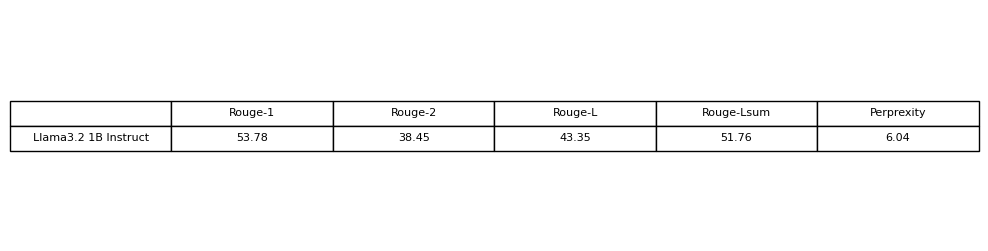

In [ ]:
data = [
    ["", "Rouge-1", "Rouge-2", "Rouge-L", "Rouge-Lsum", "Perprexity"], 
    ["Llama3.2 1B Instruct", 53.78, 38.45, 43.35, 51.76, 6.04],
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2.5, 1.5)

plt.show()

For the task of expanding abstracts, these results indicate that the Llama3.2 1B Instruct model offers a good balance between lexical accuracy (captured by Rouge scores) and fluency (reflected by perplexity). The Rouge-1 and Rouge-Lsum values suggest that it preserves many key points from the original text, while the low perplexity indicates that the output is coherent and suitable for the academic context.